In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas
import folium

## First Analysis

### 1. Economic dataset

The dataset for economic factors is divided into countries and aggregates, which are the reginal or political group of different countries. Here we would like to do an EDA on the countries dataset.

In [ ]:
economy = pd.read_csv('./Data/economy/economic_countries/countries.csv')

First we can get the list of differnt indicators in this dataset, remove some columns that are before 2015 and remove the NaNs at the bottom of the table.

In [ ]:
economy = pd.concat([economy.iloc[:, :4], economy.iloc[:, -6:]], axis=1).dropna(subset=['Country Code']).replace('..', np.nan)
economy

In [ ]:
indicators = pd.DataFrame(economy['Series Name'].unique(), columns=['Indicator Name'])
metadata = pd.read_csv('./Data/economy/economic_countries/countries_metadata.csv')
metadata = metadata[['Code', 'Indicator Name', 'Long definition']]
indicators = indicators.merge(metadata, on='Indicator Name')
indicators

Now let's have a glance of the data. In the year 2019, what are the distribution of GDP and GNI per capita among countries?

In [ ]:
data_2019 = economy[['Country Name', 'Country Code', 'Series Name', 'Series Code', '2019 [YR2019]']]
gdp_2019 = data_2019.loc[data_2019['Series Code'] == 'NY.GDP.MKTP.CD'].dropna(subset=['2019 [YR2019]']).rename(columns={'2019 [YR2019]': 'GDP'})
gdp_2019['GDP'] = gdp_2019['GDP'].astype('float')
gdp_2019['Log_GDP'] = np.log(gdp_2019['GDP'])
gdp_2019

In [ ]:
gdp_2019['GDP'].describe()

In [ ]:
gdp_2019['GDP'].skew()

Since the GDP data is extremely skewed, we can use the log of GDP to plot the histgram.

In [ ]:
sns.histplot(gdp_2019['Log_GDP'], bins=50)
plt.title('Log of GDP in 2019')
plt.xlabel('GDP (in log)')
plt.show()

In [ ]:
gnipc_2019 = data_2019.loc[data_2019['Series Code'] == 'NY.GNP.PCAP.CD'].dropna(subset=['2019 [YR2019]']).rename(columns={'2019 [YR2019]': 'GNIPC'})
gnipc_2019['GNIPC'] = gnipc_2019['GNIPC'].astype('float')
gnipc_2019

In [ ]:
gnipc_2019['GNIPC'].describe()

In [ ]:
sns.histplot(gnipc_2019['GNIPC'], bins=50)
plt.title('GNI per capita in 2019')
plt.show()

We can find a correlation between these two indicators:

In [ ]:
gdp_gnic = gnipc_2019[['Country Name', 'Country Code', 'GNIPC']].merge(gdp_2019[['Country Code', 'GDP', 'Log_GDP']], on='Country Code')
sns.scatterplot(x=gdp_gnic['Log_GDP'], y=gdp_gnic['GNIPC'])
sns.regplot(x=gdp_gnic['Log_GDP'], y=gdp_gnic['GNIPC'], scatter=False, color='orange')
plt.title('GDP - GNI per captia in 2019')
plt.show()

In [ ]:
np.corrcoef(x=gdp_gnic['Log_GDP'], y=gdp_gnic['GNIPC'])

We can also check the change of the indicator through the years. For example, what is the trend for some countries' GDP growth from 2015 to 2020?

In [ ]:
gdp_growth = economy.loc[economy['Series Code'] == 'NY.GDP.MKTP.KD.ZG']
country_list = ['USA', 'CHN', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'ITA', 'CAN', 'KOR']
gdp_growth = gdp_growth.loc[gdp_growth['Country Code'].isin(country_list)]
gdp_growth.iloc[:, -6:] = gdp_growth.iloc[:, -6:].astype('float')
gdp_growth

In [ ]:
pp = gdp_growth.drop(labels=['Country Name', 'Series Name', 'Series Code'], axis=1)
years = np.arange(2015, 2021)
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
for i in range(10):
    sns.lineplot(x=years, y=pp.iloc[i, 1:], markers=True, label=pp['Country Code'].iloc[i])
plt.title('Major Countries\' GDP Growth trend 2015-2020')

### 2. Population dataset

In [ ]:
population = pd.read_csv('./Data/population/pop_worldometer_data.csv')
population

In [ ]:
population.describe()

The distribution of the population is also extremely skewed, so we draw the histogram based on its logarithm.

In [ ]:
sns.histplot(np.log(population['Population (2020)']), bins=50)
plt.xlabel('Log of Population (2020)')
plt.title('World Population by Country (Log) in 2020')

We can also check the population growth of one country with the dataset:

In [ ]:
population_total = pd.read_csv('./Data/population/population_total_long.csv')
pop_swiss = population_total.loc[population_total['Country Name'] == 'Switzerland']
pop_swiss.head(10)

In [ ]:
sns.lineplot(data=pop_swiss, x='Year', y='Count')
plt.title('Population of Switzerland (1960-2017)')
plt.show()

### 3. Religion dataset

In [ ]:
religion_national = pd.read_csv('/Users/samiferchiou/com480/datavis-project-2022-msn/data/religion/national.csv')
religion_national

In [ ]:
christ_2010 = religion_national.loc[religion_national['year'] == 2010][['state', 'code', 'christianity_all']].rename(columns={'state': 'country'})
christ_2010

In [ ]:
sns.histplot(christ_2010.christianity_all, bins=50)
plt.title('Christianity across the world in 2010')
plt.show()

## Minimal Viable Product

### 4. Weather datasets

### 4.1. Temperature

Loading the Temperature dataset

In [ ]:
df_temperature = pd.read_csv('/Users/samiferchiou/com480/datavis-project-2022-msn/data/weather/daily_temperature_1000_cities_1980_2020.csv')
df_temperature = df_temperature.rename(columns={'Unnamed: 0': 'Index'}).set_index('Index')

In [159]:
tmp1 = df_temperature.loc['city':'iso3',:]
tmp2 = df_temperature.loc['2018-01-12':'2018-12-31',:]
df_tmp = pd.concat([tmp1, tmp2]).transpose().drop(columns=['city','lat','lng','iso2']).rename(columns={'city_ascii': 'city', 'iso3': 'code'})
avg_tmp = df_tmp.drop(columns=['code','city']).set_index('country').groupby('country').apply(np.mean).mean(axis=1)
df_tmp

/Users/samiferchiou/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Index,city,country,code,2018-01-12,2018-01-13,2018-01-14,2018-01-15,2018-01-16,2018-01-17,2018-01-18,...,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
0,Tokyo,Japan,JPN,2.17,3.42,3.54,5.53,7.67,8.33,8.9,...,9.51,9.17,6.03,5.59,8.07,6.96,3.5,3.82,4.3,4.99
1,New York,United States,USA,6.69,-6.56,-6.0,-1.47,1.43,-3.95,-1.76,...,4.41,3.82,2.88,2.13,3.18,8.15,10.23,3.19,3.55,10.31
2,Mexico City,Mexico,MEX,11.06,6.83,8.14,9.93,9.0,9.63,10.44,...,11.08,10.63,12.24,12.08,11.95,11.82,12.66,13.12,12.28,12.33
3,Mumbai,India,IND,25.49,25.69,25.8,26.12,26.28,25.75,25.64,...,24.75,24.96,25.27,24.78,23.47,22.68,22.59,22.93,23.23,23.2
4,Sao Paulo,Brazil,BRA,22.23,23.47,24.0,23.73,24.18,25.49,23.97,...,23.19,21.66,20.53,20.93,21.8,22.13,22.91,23.74,23.41,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Yangzhou,China,CHN,-1.94,2.45,3.97,8.59,6.53,5.39,6.03,...,8.62,5.91,7.77,7.95,5.07,1.53,-3.13,-1.7,-0.97,1.61
996,Novokuznetsk,Russia,RUS,-9.03,-13.04,-19.54,-16.63,-12.67,-11.2,-12.32,...,-14.52,-16.22,-23.98,-28.57,-29.06,-29.79,-30.47,-30.87,-25.91,-17.87
997,Latakia,Syria,SYR,14.94,15.39,13.05,13.98,14.79,14.2,14.3,...,15.52,15.84,15.83,15.58,15.83,12.63,12.64,12.54,11.49,11.97
998,Heroica Matamoros,Mexico,MEX,11.73,13.1,17.61,13.1,0.84,4.17,7.3,...,19.89,19.73,21.03,22.34,23.89,19.07,18.3,9.66,13.04,15.88


#### 4.2. Sunshine

Loading the Sunshine dataset

In [175]:
df_sunshine = pd.read_csv('/Users/samiferchiou/com480/datavis-project-2022-msn/data/weather/sunshine_hours_by_city.csv')
avg_sun = df_sunshine.drop(columns=['City']).rename(columns={'Country':'country'})
avg_sun.at[97,'country'] = 'Congo (Kinshasa)'
avg_sun.at[98,'country'] = 'Congo (Kinshasa)'
avg_sun = avg_sun.groupby('country').mean().mean(axis=1)
avg_sun

country
Afghanistan    488.476923
Albania        391.384615
Algeria        503.119231
Angola         360.076923
Argentina      341.584615
                  ...    
Uzbekistan     434.446154
Venezuela      445.438462
Vietnam        326.673077
Zambia         456.225641
Zimbabwe       471.600000
Length: 140, dtype: float64

### 5. Happiness datasets

Loading the Hapinness rate dataset

In [182]:
df_happiness_2018 = pd.read_csv('/Users/samiferchiou/com480/datavis-project-2022-msn/data/happiness/2018.csv')
df_happiness_2018 = df_happiness_2018.set_index('Overall rank').rename(columns={'Country or region': 'country','Score': 'score'}).loc[:,:'score']
df_happiness_2018

,country,score
Overall rank,,
1,Finland,7.632
2,Norway,7.594
3,Denmark,7.555
4,Iceland,7.495
5,Switzerland,7.487
...,...,...
152,Yemen,3.355
153,Tanzania,3.303
154,South Sudan,3.254


Putting all datasets together

In [176]:
a = pd.DataFrame([avg_tmp]).transpose().rename(columns={0:'avg_temperature'})
b = pd.DataFrame([avg_sun]).transpose().rename(columns={0:'avg_sunshine'})
final = df_happiness_2018.merge(a, on='country').merge(b, on ='country')
final

,country,score,avg_temperature,avg_sunshine
0,Finland,7.632,6.975226,285.846154
1,Norway,7.594,7.174266,211.282051
2,Denmark,7.555,10.165678,297.282051
3,Iceland,7.495,5.158362,204.076923
4,Switzerland,7.487,11.084746,297.326923
...,...,...,...,...
111,Malawi,3.587,21.519209,430.128205
112,Tanzania,3.303,22.961733,466.976923
113,South Sudan,3.254,28.304492,437.123077
114,Central African Republic,3.083,26.273164,391.769231


Creating the worlwide happiness map

In [177]:
# Read the geopandas dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#correcting important matching
world.at[4,'name'] = 'United States'
world.at[66,'name'] = 'Central African Republic'
world.at[176,'name'] = 'South Sudan'
world.at[11,'name'] = 'Congo (Kinshasa)'
table = world.merge(final, how="right", left_on=['name'], right_on=['country'])
# Clean data: remove rows with no data
table = table.dropna(subset=['name'])

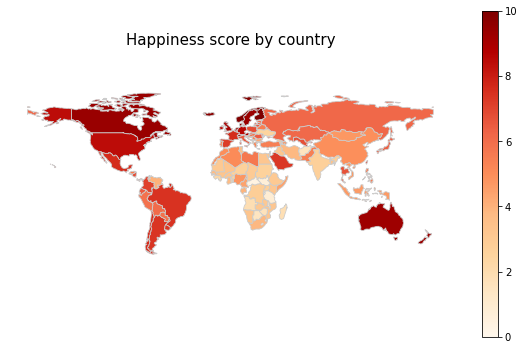

In [178]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'score'
# set the range for the choropleth
vmin, vmax = 0, 10
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

table.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
ax.set_title('Happiness score by country\n\n', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [179]:
# Create a map
my_map = folium.Map()
# Add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['country', 'score'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Happinees Score by Country'
).add_to(my_map)
my_map

Creating the worlwide temperature map

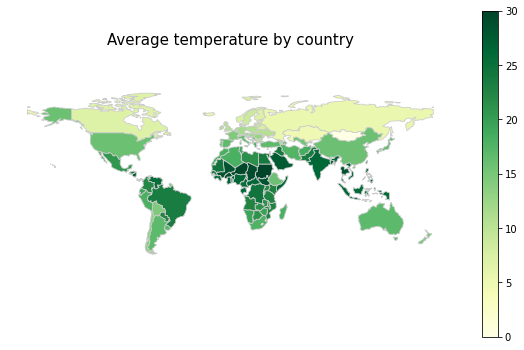

In [180]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'avg_temperature'
# set the range for the choropleth
vmin, vmax = 0, 30
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

table.plot(column=variable, cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')
# add a title
ax.set_title('Average temperature by country\n\n', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [181]:
# Create a map
tmp_map = folium.Map()
# Add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['country', 'avg_temperature'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Temperature by Country'
).add_to(tmp_map)
tmp_map